In [2]:
from pymeasure.instruments import list_resources
list_resources()

0 : USB0::0x05E6::0x2450::04491080::INSTR : KEITHLEY INSTRUMENTS,MODEL 2450,04491080,1.7.3c


('USB0::0x05E6::0x2450::04491080::INSTR',)

In [56]:
import datetime
import os
import sys
from utilities import make_folder, int_ask

# Set the project name
user_list = os.listdir('/Users/lznus/Desktop/Data-Keithley/')
for i, user in enumerate(user_list):
    print(f'\033[33m{i+1:02}: {user}\033[33m')
print('\033[31mSelect your user ID\033[33m')
user_ID = int(input(''))
user_name = user_list[user_ID-1]

today = datetime.datetime.today().strftime('%y%m%d')

# Set the project name if you need
print('\033[31mCreate a new folder (0) or Use an existing folder (1)\033[33m')
mkdir_option = int_ask('')

if mkdir_option == 0:
    print('\033[31mEnter project name: \033[33m')
    project_name = input('')
    while project_name == '':
        print('\033[31mError: Project name cannot be empty\nEnter project name: \033[33m')
        project_name = input('')
    # Define the name
    project_dir = f"/Users/lznus/Desktop/Data-Keithley/{user_name}/{today}_IV-continuous_{project_name}"
    fig_dir = f"{project_dir}/figures"
    
elif mkdir_option == 1:
    folder_list = os.listdir(f"/Users/lznus/Desktop/Data-Keithley/{user_name}")
    for i, folder in enumerate(folder_list):
        print(f'\033[33m{i+1:02}: {folder}\033[33m')
    print('\033[31mSelect your folder ID\033[33m')
    folder_ID = int(input(''))
    project_dir = f"/Users/lznus/Desktop/Data-Keithley/{user_name}/{folder_list[folder_ID-1]}"
    fig_dir = f"{project_dir}/figures"

01: Paul
02: Ren
03: Soumya
04: Yuki
Select your user ID


 4


Create a new folder (0) or Use an existing folder (1)


 1


01: 221102
02: 221107
03: 221202
04: 221206
05: 221213
06: 221219
07: 230426_vacuum-chamber-test
08: 230427_vacuum-chamber-test-11.9uGys
09: 230427_vacuum-chamber-test-1Torr-various-dose-rate
10: 230427_vacuum-chamber-test-9.68mGys
11: 230427_vacuum-chamber-test-one-glass
12: 230427_vacuum-leaking-9.68mGys
13: 230428_test
14: 230501_tI_221207-MAPbBr3
15: 230501_tI_vacuum-test-with-large-collimator
16: 230502_tI_221207-air
17: 230502_tI_Ahmed-MAPbBr2-no-passivation
18: 230502_tI_program-test
19: 230509_IV_Ahmed-Au-MAPbBr3-Ga
20: 230509_tI_Ahmed-Au-MAPbBr3-Ga
21: 230512_IV_BiPhPbBr
22: 230512_tI_Ahmed-MAPbBr3-2nd-measurement
23: 230512_tI_BiPhPbBr
24: 230526_IV_02vs05_MAPbBr3
25: 230526_tI_0.2-0.5-MAPbBr3_Cu-BCP-C60_Au
26: 230530
27: 230530_IV_MAPbBr3-SCLC-Continuous
28: 230530_IV_mu-tau-test
29: 230530_SCLC-pulse_MAPbBr3-first-try
30: 230530_tI_mu-tau-test
31: 230530_tI_mu-tau-test-pulse
32: 230531_tI_MAPbBr3-Hecht-1SUN
33: 230602_IV_Au-MPB-Ga_polished_02-05
34: 230602_tI_Au-MPB-Ga_poli

 63


In [77]:
import numpy as np
# Set parameters
start_voltage = 0 #V
end_voltage = 50 # V
step_size = 2 #V/step
scan_rate = 10 #V/s
cur_limit = 0.05 # A
direction = 'F' # B:both (F to R), F:forward, R:reverse

if start_voltage > end_voltage:
    step_size = (-1)*step_size
source_voltage = np.arange(start_voltage, end_voltage+step_size, step_size) # prepare voltage sources
source_voltage_R = list(source_voltage)
source_voltage_R.reverse()
total_time = abs(end_voltage - start_voltage) / scan_rate
delay_time =  total_time / len(source_voltage)
if direction == 'B':
    total_time = total_time * 2
# Set the filename
file_name = input('Enter file name: ')
filename = f'{project_dir}/{file_name}-F.csv'
filename_R = f'{project_dir}/{file_name}-R.csv'
if max(source_voltage)*cur_limit > 5:
    print('invalid limit! output should be less than 5 W')
    
# if total_time < 60:
#     print(f'Estimated total time is {int(total_time)} sec')
# elif total_time >= 60 and total_time <= 3600:
#     print(f'Estimated total time is {int(total_time)/60} min')
# elif total_time > 3600:
#     print(f'Estimated total time is {int(total_time)/3600} hrs')

Enter file name:  Control_dark_positive_5


Program completed


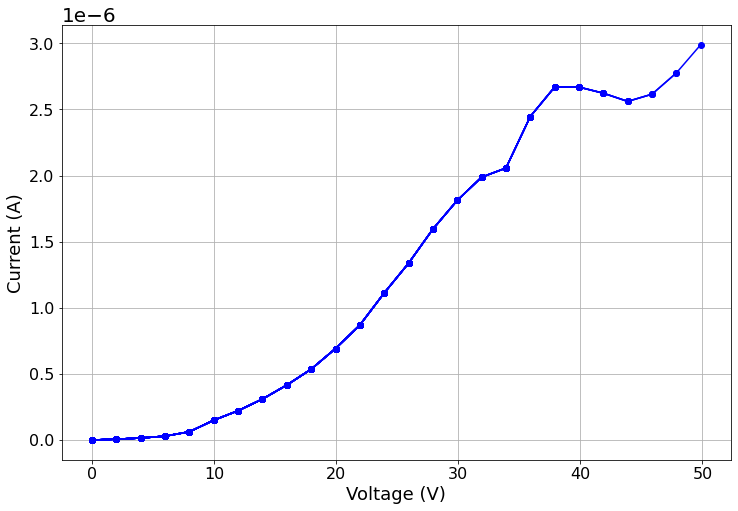

In [78]:
import pyvisa as visa
import time
import csv
import datetime
import sys
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

# Create the project directory if it does not exist
make_folder(project_dir)
# Create the project directory if it does not exist
make_folder(fig_dir)

# Check Parameters
print(f'File name: {file_name}.csv')
print(f'Range: from {start_voltage} V to {end_voltage} V')
print(f'Scan rate: {scan_rate} V/s')

# Make sure if you start or not
START = input('Press Enter to Start')
if START == '':
    print("\n Let's get started :)")
    pass
else:
    sys.exit(0)
    
# Open a connection to the Keithley 2450
try:
    rm = visa.ResourceManager()
    keithley = rm.open_resource('USB0::0x05E6::0x2450::04491080::INSTR')
except:
    print("Error: Could not connect to instrument")
    sys.exit(0)

# Initialize the time and current arrays
times = []
currents = []
voltages = []

# Set up the real-time plot
plt.ion()
fig = plt.figure(figsize=(12,8))
plt.rcParams["font.size"] = 20
plt.xlabel('Voltage (V)')
plt.ylabel('Current (A)')
# Set the voltage source output on
keithley.write(f'SOURCE:VOLTAGE:LEVEL 0') 
keithley.write(f':SOUR:VOLT:ILIMIT {cur_limit}')
keithley.write('OUTPUT ON')

# Start the measurement and real-time plot
start_time = time.perf_counter()
for i in range(len(source_voltage)):
    round_start = time.perf_counter()
    # Set the voltage source
    keithley.write(f'SOURCE:VOLTAGE:LEVEL {source_voltage[i]}') 
    clear_output(wait=True)
    voltage = float(keithley.query('MEASURE:VOLTAGE?'))
    current = float(keithley.query('MEASURE:CURRENT?'))
    times.append((time.perf_counter() - start_time))
    currents.append(current)
    voltages.append(voltage)
    print(f'Time: {times[-1]:.2f} s')
    print(f'Voltage: {voltage:.4g} V')
    print(f'Current: {current:.4g} A')
    plt.plot(voltages, currents, linestyle='-', marker='o', label='Current', color='blue')
    plt.xlabel('Voltage (V)', fontsize=18)
    plt.ylabel('Current (A)', fontsize=18)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.grid(True)
    display(fig)
    if (delay_time - (time.perf_counter() - round_start)) > 0:
        time.sleep(delay_time - (time.perf_counter() - round_start))
    else:
        pass

clear_output(wait=True)
# Set the voltage source output off
keithley.write('OUTPUT OFF')

# Create a CSV file for saving the data
with open(filename, 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(['Time (s)', 'Current (A)', 'Voltage (V)'])
    for i in range(len(times)):
        csvwriter.writerow([times[i], currents[i], voltages[i]])

# Check that the CSV file was created successfully
try:
    with open(filename, 'r') as csvfile:
        pass
except:
    
    print("Error: Could not create CSV file")

# start reverse scan
if not direction == 'F':
    # Initialize the time and current arrays
    times_R = []
    currents_R = []
    voltages_R = []

    # Set the voltage source output on
    keithley.write(f'SOURCE:VOLTAGE:LEVEL 0') 
    keithley.write('OUTPUT ON')

    # Start the measurement and real-time plot
    start_time = time.perf_counter()
    for i in range(len(source_voltage_R)):
        round_start = time.perf_counter()
        # Set the voltage source
        keithley.write(f'SOURCE:VOLTAGE:LEVEL {source_voltage_R[i]}') 
        clear_output(wait=True)
        voltage = float(keithley.query('MEASURE:VOLTAGE?'))
        current = float(keithley.query('MEASURE:CURRENT?'))
        times_R.append((time.perf_counter() - start_time))
        currents_R.append(current)
        voltages_R.append(voltage)
        print(f'Time: {times_R[-1]:.2f} s')
        print(f'Voltage: {voltage:.4g} V')
        print(f'Current: {current:.4g} A')
        plt.plot(voltages, currents, linestyle='-', marker='o', label='Current', color='blue')
        plt.plot(voltages_R, currents_R, linestyle='-', marker='o', label='Current', color='green')
        plt.xlabel('Voltage (V)', fontsize=18)
        plt.ylabel('Current (A)', fontsize=18)
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        plt.grid(True)
        display(fig)
        if (delay_time - (time.perf_counter() - round_start)) > 0:
            time.sleep(delay_time - (time.perf_counter() - round_start))
        else:
            pass

    clear_output(wait=True)
    # Set the voltage source output off
    keithley.write('OUTPUT OFF')

    # Create a CSV file for saving the data
    with open(filename_R, 'w', newline='') as csvfile:
        csvwriter = csv.writer(csvfile)
        csvwriter.writerow(['Time (s)', 'Current (A)', 'Voltage (V)'])
        for i in range(len(times)):
            csvwriter.writerow([times_R[i], currents_R[i], voltages_R[i]])

    # Check that the CSV file was created successfully
    try:
        with open(filename_R, 'r') as csvfile:
            pass
    except:

        print("Error: Could not create CSV file")
# Close the connection to the Keithley 2450
keithley.close()

print("Program completed")

In [31]:
filename

'/Users/lznus/Desktop/Data-Keithley/Yuki/230905_IV-continuous_Ahmed-SCLC-relaxation-FR\\DCM-A-F.csv'

In [7]:
pip install pyvisa-py

Note: you may need to restart the kernel to use updated packages.Installing collected packages: pyvisa-py



In [79]:
import glob
import os
data_list = glob.glob(f'{project_dir}/*.csv')
csv_list = []

for i, file in enumerate(data_list):
    csv_list.append(os.path.splitext(os.path.basename(file))[0])
    print(f'{i}: {os.path.splitext(os.path.basename(file))[0]}')

0: Control_25.2uGys_negative_3-F
1: Control_25.2uGys_positive_4-F
2: Control_dark_negative_6-F
3: Control_dark_positive_4-F
4: Control_dark_positive_5-F
5: DCM_25.2uGys_negative_2-F
6: DCM_dark_negative_2-F


0: Control_25.2uGys_positive_4-F
1: Control_dark_positive_4-F
2: Control_dark_positive_5-F


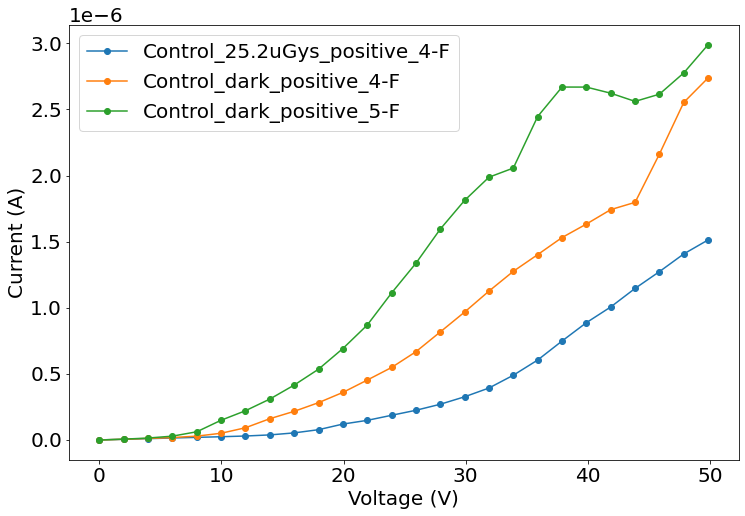

In [80]:
plot_index = [1,3,4] # Chose the numbers
save = False

if save:
    fig_name = input('Input Figure Name')

plot_list = []
for i in range(len(plot_index)):
    plot_list.append(csv_list[plot_index[i]])

for i, file in enumerate(plot_list):
    print(f'{i}: {file}')
    
import pandas as pd

figure = plt.figure(figsize=(12,8))
plt.rcParams["font.size"] = 20
plt.xlabel('Voltage (V)')
plt.ylabel('Current (A)')

for file in plot_list:
    df = pd.read_csv(f'{project_dir}/{file}.csv')
    plt.plot(df['Voltage (V)'], df['Current (A)'], linestyle='-', marker='o', label = file)

plt.legend()
plt.show()

if save:
    # Create the project directory if it does not exist
    fig_com_dir = f"{fig_dir}/combined"
    make_folder(fig_com_dir)
    fig_com_path = os.path.join(fig_com_dir, fig_name + '.png')
    figure.savefig(fig_com_path, transparent = True)

In [ ]:
figure = plt.figure(figsize=(12,8))
plt.rcParams["font.size"] = 20
plt.xlabel('Voltage (V)')
plt.ylabel('Current (A)')

for file in plot_list:
    df = pd.read_csv(f'{project_dir}/{file}.csv')
    plt.plot(df['Voltage (V)'], df['Current (A)'], linestyle='-', marker='o', label = file)

plt.legend()
plt.ylim(-0.1*1e-10,0.1*1e-10)
plt.show()

In [ ]:
plot = [input('Chose the numbers')]
plot